# 3.3.8 再検討した簡易入力方法のUA、ηAC、ηAHの再現性確認 (共同住宅のみ・756通り)

### 必要なモジュールのimport

In [6]:
import os, sys
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

sys.path.append("../experiments")
from common.web_input import create_web_input_from_house_data
from common.house_data import HouseData
from common.utils.func import load_json

### データ生成

まず以下のコマンドでコントロール群のデータを生成する。
```
python3 -m sample_generator.condition_generator > sample_generator/index.csv
python3 -m sample_generator.input_excel_creator
python3 -m sample_generator.input_json_creator
```

In [12]:
index_csvpath = os.path.join('..', 'experiments', 'sample_generator', 'index.csv')
with open(index_csvpath, mode='r', encoding='utf-8', newline='') as index_csvfile:
    index_csvreader = csv.DictReader(index_csvfile)
    test_params = [_.values() for _ in index_csvreader]

次に、新しい簡易入力方法( simple_input_test.py: estimate関数) を用いて対照群のデータを作成する。

In [19]:
import json
from simple_input_r5 import estimate, to_json


# 新しい計算法で入力JSONを生成する関数
def create_new_house_data(
    index: str,
    region_name: str,
) -> None:
    region = {
        '岩見沢':   2,
        '岡山':     6,
        '那覇':     8,
    }[region_name]

    # コントロールデータ
    testcase_dirpath = os.path.join('..', 'experiments', 'sample_generator','input_json', str(index))
    house_data_path = os.path.join(testcase_dirpath, 'house_data.json')
    house_data = load_json(house_data_path, data_class=HouseData)
    web_input = create_web_input_from_house_data(region, house_data)

    # 対照群の入力Excelを生成
    new_input_xlsx_path = os.path.join(testcase_dirpath, 'new_input.xlsx')
    estimate(region=web_input.region,
             total_floor_area=web_input.A_A,
             main_floor_area=web_input.A_MR,
             other_floor_area=web_input.A_OR,
             A_env=web_input.A_env,
             ua=web_input.U_A,
             eta_ac=web_input.eta_A_C,
             eta_ah=web_input.eta_A_H,
             tatekata='共同住宅',
             structure=None,
             xlsx_path=new_input_xlsx_path)

    # 対照群の入力JSONを生成
    new_house_data = to_json(new_input_xlsx_path)
    new_house_data_path = os.path.join(testcase_dirpath, 'new_house_data.json')
    with open(new_house_data_path, mode='w') as new_house_data_file:
        json.dump(new_house_data, new_house_data_file, indent=4)


for index, _, _, _, _, region_name, _ in test_params:
    create_new_house_data(index, region_name)


計算条件
-------------------------------------------------
地域区分: 6
延床面積: 69.996 [㎡]
 主たる居室: 24.7479 [㎡]
 その他居室: 29.7506 [㎡]
外皮総面積: 241.02240000000003 [㎡]
外皮平均熱貫流率: 0.9503172180326471 [W/K]
暖房期平均日射熱取得率: 2.429677755855732
冷房期平均日射熱取得率: 2.3156408486372277

計算結果
-------------------------------------------------
外皮面積
  主たる居室: 18.32 0.00 0.00 33.12 [㎡]
  その他居室: 11.55 38.65 21.12 18.01 [㎡]
  非居室:     0.00 16.70 8.63 4.92 [㎡]
外気に接する屋根の面積
  主たる居室: 1.19 [㎡]
  その他居室: 1.43 [㎡]
  非居室:     0.75 [㎡]
外気に接する外壁・基礎壁の面積
  主たる居室: 13.32 0.00 0.00 1.59 [㎡]
  その他居室: 7.97 1.86 18.33 0.87 [㎡]
  非居室:     0.00 0.80 6.69 0.24 [㎡]
  床下空間:   0.00 0.00 0.00 0.00 [㎡]
窓面積
  主たる居室: 5.00 0.00 0.00 0.00 [㎡]
  その他居室: 3.58 0.00 2.80 0.00 [㎡]
  非居室:     0.00 0.00 0.00 0.00 [㎡]
ドア面積
  主たる居室: --- --- 0.00 0.00 [㎡]
  その他居室: --- --- 0.00 0.00 [㎡]
  非居室:     --- --- 1.95 0.00 [㎡]
間仕切り
  主居室 - その他居室: 23.02 [㎡]
  主居室 - 非居室: 32.02 [㎡]
  その他居室 - 非居室: 75.13 [㎡]
床下空間と居室が接する床の面積（基礎断熱のみ）
  主居室 - 床下空間: 0.00 [㎡]
  その他居室 - 床下空間: 0.00 [㎡]
  非居室 -

コントロール群・対照群それぞれについて、UA, ηAC, ηAHを算出する。

In [21]:
def create_web_input_dicts(
    index: str,
    model_plan: str,
    direction: str,
    floor: str,
    place: str,
    region_name: str,
    insulation: str,
) -> dict:
    region = {
        '岩見沢':   2,
        '岡山':     6,
        '那覇':     8,
    }[region_name]

    # コントロールデータ
    testcase_dirpath = os.path.join('..', 'experiments', 'sample_generator','input_json', str(index))
    house_data_path = os.path.join(testcase_dirpath, 'house_data.json')
    house_data = load_json(house_data_path, data_class=HouseData)
    web_input = create_web_input_from_house_data(region, house_data)

    # 対照群
    new_house_data_path = os.path.join(testcase_dirpath, 'new_house_data.json')
    new_house_data = load_json(new_house_data_path, data_class=HouseData)
    new_web_input = create_web_input_from_house_data(region, new_house_data)

    # 従来の簡易入力方法との比較のため、ηAHとηACを暖冷房期間で案分した値を出力する。
    # (現状の計算方法ではηAH, ηAC両方の値を保証することができないため)
    day_h, day_c = [
        [257, 53],
        [252, 48],
        [244, 53],
        [242, 53],
        [218, 57],
        [169, 117],
        [122, 152],
        [0, 265],
    ][region - 1]
    eta_A_x = (web_input.eta_A_H * day_h + web_input.eta_A_C * day_c) / (day_h + day_c)
    eta_A_y = (new_web_input.eta_A_H * day_h + new_web_input.eta_A_C * day_c) / (day_h + day_c)

    return {
        '間取り': model_plan,
        '主開口方位': direction,
        '階': floor,
        '住戸位置': place,
        '地域': region_name,
        '断熱性能': insulation,
        'U_A_x': web_input.U_A,
        'eta_A_H_x': web_input.eta_A_H,
        'eta_A_C_x': web_input.eta_A_C,
        'eta_A_x': eta_A_x,
        'U_A_y': new_web_input.U_A,
        'eta_A_H_y': new_web_input.eta_A_H,
        'eta_A_C_y': new_web_input.eta_A_C,
        'eta_A_y': eta_A_y,
    }

web_input_dicts = [create_web_input_dicts(*_) for _ in test_params]


データフレームを作成し、中身を確認する。

In [22]:
web_input_df = pd.DataFrame(web_input_dicts)
web_input_df.head()

,間取り,主開口方位,階,住戸位置,地域,断熱性能,U_A_x,eta_A_H_x,eta_A_C_x,eta_A_x,U_A_y,eta_A_H_y,eta_A_C_y,eta_A_y
0,3LDK一般,南,最上階,右側妻住戸,岡山,H4,0.950317,2.429678,2.315641,2.383026,0.950800,2.519591,2.187669,2.383805
1,3LDK一般,南,最上階,右側妻住戸,岡山,H11,0.683380,1.785032,1.701760,1.750966,0.683698,1.867779,1.583554,1.751505
2,3LDK一般,南,最上階,右側妻住戸,岡山,H11超,0.500042,1.428341,1.368018,1.403663,0.500196,1.486314,1.284919,1.403925
3,3LDK一般,南,最上階,右側妻住戸,岩見沢,H4,0.386447,1.340210,1.470214,1.361010,0.386526,1.343909,1.451662,1.361150
4,3LDK一般,南,最上階,右側妻住戸,岩見沢,H11,0.340906,1.230182,1.367254,1.252114,0.340963,1.234563,1.344881,1.252214


最後に、UA、ηAC、ηACの3パラメータについて、コントロールデータと対照群の値を比較した散布図を作成する。従来の簡易入力法とは異なり、上限値・下限値のクリップによる値の激しいずれは見られなくなった。

### 個別のチャート

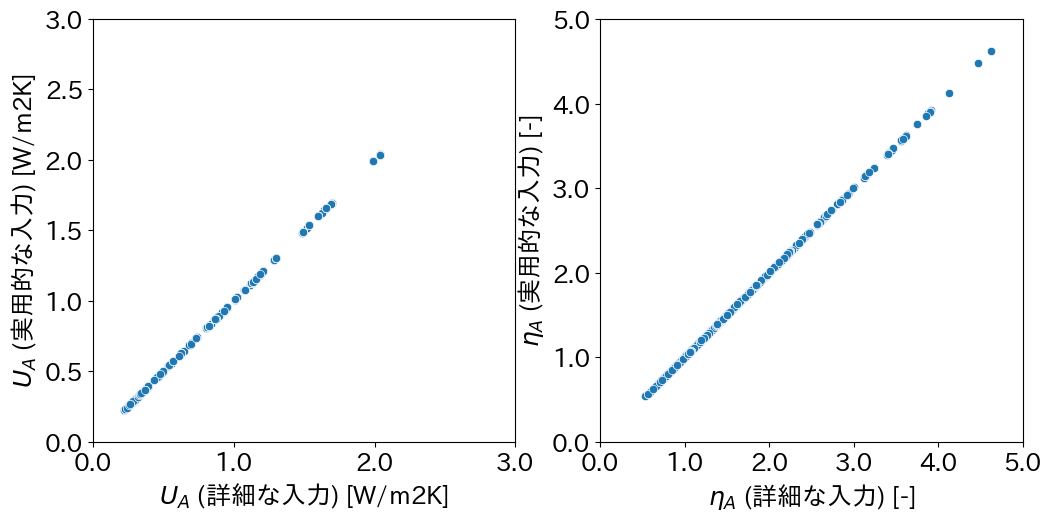

In [39]:
from matplotlib.ticker import FormatStrFormatter

# 全体のフォントサイズを設定
plt.rcParams['font.size'] = 18

# 2つのサブプロットを作成（1行2列）
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# 最初のプロット
sns.scatterplot(data=web_input_df, x='U_A_x', y='U_A_y', ax=axes[0])
axes[0].set_xlim([0, 3.0])
axes[0].set_ylim([0, 3.0])
axes[0].set_xlabel(r'$U_{A}$ (詳細な入力) [W/m2K]')
axes[0].set_ylabel(r'$U_{A}$ (実用的な入力) [W/m2K]')
axes[0].set_aspect('equal')
axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#axes[0].set_title('U_Aの散布図')  # オプションでタイトルを追加

# 二番目のプロット
sns.scatterplot(data=web_input_df, x='eta_A_x', y='eta_A_y', ax=axes[1])
axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[1].set_xlim([0, 5.0])
axes[1].set_ylim([0, 5.0])
axes[1].set_xlabel(r'$\eta_{A}$ (詳細な入力) [-]')
axes[1].set_ylabel(r'$\eta_{A}$ (実用的な入力) [-]')
axes[1].set_aspect('equal')
#axes[1].set_title('eta_Aの散布図')  # オプションでタイトルを追加